In [1]:
%pylab widget
%load_ext autoreload

%autoreload 2

Populating the interactive namespace from numpy and matplotlib


### Now what would fastCat think of this?

#### We can loop through this

This runs off of a modified xpecgen that returns only the doses and 

In [28]:
import sys
import os
import tigre
from scipy.signal import fftconvolve

import fastcat.fastcat as fc

dose = 0

# phan_map_hard =  ['air','water','Spongiosa_Bone_ICRP','G4_BONE_COMPACT_ICRU',
#              'G4_BONE_CORTICAL_ICRP','C4_Vertebra_ICRP','D6_Vertebra_ICRP','G4_B-100_BONE']

phan_map_hard =  ['air','water','water','water',
             'water','water','water','water']


phan_map_g4 = ['air','water','G4_LUNG_ICRP',"G4_BONE_COMPACT_ICRU","G4_BONE_CORTICAL_ICRP","G4_ADIPOSE_TISSUE_ICRP","G4_BRAIN_ICRP","G4_B-100_BONE"] 

spectrum_files = sorted(['120_kVp','Al_spectrum_25', 'C_spectrum_6', 'Al_spectrum_6', 'C_spectrum_25', 'W_spectrum_6', 'W_spectrum_25'])
# spectrum_files = sorted(['Al_spectrum_25', 'C_spectrum_6', 'Al_spectrum_6', 'C_spectrum_25', 'W_spectrum_6', 'W_spectrum_25'])

dets = ['CuGOS-784-micrometer']

phan_maps = [phan_map_hard]#,phan_map_soft]

angles = np.linspace(0,2*np.pi,2)

res = []

original_energies_keV = np.array([30, 40, 50 ,60, 70, 80 ,90 ,100 ,300 ,500 ,700, 900, 1000 ,2000 ,4000 ,6000])


angles = np.linspace(0,2*pi,2)

geo = 'catphan_low_contrast_512'

phantom = fc.Catphan_515()

for phan_map in phan_maps:
    for spectrum_file in spectrum_files[:]:
        for det in dets:
            
            if spectrum_file == '120_kVp':
                s = fc.calculate_spectrum(120, 12, 3, 50,monitor=None)
                s.attenuate(0.1,fc.get_mu(z=13))
            else:
                s = fc.Spectrum()
                s.load(spectrum_file)
        
            kernel = fc.Kernel(s, det)
            
#             kernel.add_focal_spot(0.1)

            energy_deposition_file = os.path.join(
                fc.data_path, "Detectors", det, 'EnergyDeposition.npy')
            energies = s.x
            fluence = s.y
            deposition_efficiency_file = energy_deposition_file

            res.append(phantom.return_projs(kernel,s,angles,
                                       nphoton=2e7,
                                      mgy=dose,return_dose=True))

#             img_fc = tigre.algorithms.FDK(
#                 np.transpose(np.array(projs_fc[0]),[0,2,1]), phantom.geomet,angles)

#             res.append([[phan_map,spectrum_file,det],phantom.analyse_515(img_fc[5])])

(19, 41, 41) 19
bowtie is off False
really doing it!
ratio is 1.0 number of photons 0.07104375195840185
(19, 41, 41) 19
bowtie is off False
really doing it!
ratio is 1.0 number of photons 0.04845504309805526
(19, 41, 41) 19
bowtie is off False
really doing it!
ratio is 1.0 number of photons 0.03402763640736402
(19, 41, 41) 19
bowtie is off False
really doing it!
ratio is 1.0 number of photons 0.04026543917603216
(19, 41, 41) 19
bowtie is off False
really doing it!
ratio is 1.0 number of photons 0.03243039447096263
(19, 41, 41) 19
bowtie is off False
really doing it!
ratio is 1.0 number of photons 0.01015508406165716
(19, 41, 41) 19
bowtie is off False
really doing it!
ratio is 1.0 number of photons 0.0053004634067323865


In [19]:
plt.figure()
plt.plot([res[ii][-1] for ii in range(len(res))],'b*')
plt.xticks(ticks=range(len(spectrum_files)),labels=spectrum_files,rotation=75)
plt.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Working attempt

In [20]:
spectrum_files = sorted(['120_kVp','Al_spectrum_25', 'C_spectrum_6', 'Al_spectrum_6', 'C_spectrum_25', 'W_spectrum_6', 'W_spectrum_25'])

plt.figure()

doses = res[0][0]
doses_fc = []

# Loading the file from the monte carlo
deposition = np.load(deposition_efficiency_file,allow_pickle=True)

for jj,spectrum_file in enumerate(spectrum_files):
    if spectrum_file == '120_kVp':
        s = fc.calculate_spectrum(120, 12, 3, 50,monitor=None)
        s.attenuate(0.1,fc.get_mu(z=13))
    else:
        s = fc.Spectrum()
        s.load(spectrum_file)
        
    kernel = fc.Kernel(s, det)
    energy_deposition_file = os.path.join(
        fc.data_path, "Detectors", det, 'EnergyDeposition.npy')
    energies = s.x
    fluence = s.y

    # These are what I used in the Monte Carlo
    original_energies_keV = np.array([10,20,30, 40, 50 ,60, 70, 80 ,90 ,100 ,300 ,500 ,700, 900, 1000 ,2000 ,4000 ,6000])

    # This is a scaling factor that I found to work to convert energy deposition to photon probability eta
    deposition_summed = deposition[0]/(original_energies_keV/1000)/1000000
    fluence_norm = fluence/np.sum(fluence)
    deposition_long = np.interp(energies,original_energies_keV/1000,deposition_summed)
    nphotons_at_energy = fluence_norm*deposition_long
    nphotons_av = np.sum(nphotons_at_energy)
    
    # Binning to get the fluence per energy
    large_energies = np.linspace(0,6000,3001) #keV
    fluence_large = np.interp(large_energies,np.array(energies), fluence)
    fluence_small = np.zeros(len(original_energies_keV))
    
    inds = []
    # Still binning
    for ii, val in enumerate(large_energies):

        index = np.argmin(np.abs(original_energies_keV-val))
        fluence_small[index] += fluence_large[ii] 
        inds.append(index)

    # Normalize
    fluence_small /= np.sum(fluence_small)

    # Sum over the image dimesions to get the energy intensity and multiply by fluence
    doses_fc.append((doses/1000)@((fluence_small)))

plt.plot(doses_fc,'x')    
plt.xticks(ticks=range(len(spectrum_files)),labels=spectrum_files,rotation=75)
plt.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(19, 41, 41) 19
(19, 41, 41) 19
(19, 41, 41) 19
(19, 41, 41) 19
(19, 41, 41) 19
(19, 41, 41) 19
(19, 41, 41) 19


In [21]:
spectrum_files

['120_kVp',
 'Al_spectrum_25',
 'Al_spectrum_6',
 'C_spectrum_25',
 'C_spectrum_6',
 'W_spectrum_25',
 'W_spectrum_6']

In [4]:
figure();plot(large_energies/1000,100*fluence_large/sum(fluence_large));bar(original_energies_keV/1000,fluence_small/10);plot(large_energies/1000,np.array(inds)/1000)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [24]:
doses = np.array([
6.033596460814806e-08,
1.613708349168519e-07,
1.313530049174005e-07,
6.200432949299284e-07,
3.304057543118688e-07,
2.999242099122057e-07,
3.515523019359534e-07,
])

names = np.array([
'Dose_120_kVp',
'Dose_Al_spectrum_25'  ,
'Dose_C_spectrum_25'  ,
'Dose_W_spectrum_6',
'Dose_Al_spectrum_6'  , 
'Dose_C_spectrum_6',
'Dose_W_spectrum_25'])

indeces = np.argsort(names)


names = names[indeces]
doses = doses[indeces]

indeces = np.argsort(doses)

names = names[indeces]
doses = doses[indeces]


In [25]:
doses/20000000/(1.6021766e-16 * 1000)

array([0.01882937, 0.04099205, 0.05035988, 0.09359899, 0.10311153,
       0.10971085, 0.1935003 ])

In [6]:
import pandas as pd
import scipy as sp
d_norm = doses#/sum(doses)
doses_fc2 = np.array(doses_fc)
doses_fc2 = doses_fc2[indeces]
shorts = ['120 kVp', 'C 2.5 MV', 'Al 2.5 MV', 'C 6 MV',
       'Al 6 MV', 'W 2.5 MV', 'W 6 MV']
fig = plt.figure(figsize=[8,4],dpi=300)
ax1 = fig.add_subplot(121)
scats = np.load('../paper_2/curves_all.npy')
real_spec = np.load('../data/w_spec_profile.npy')
real_spec_CT = np.load('/home/xcite/scintillators/Catphan_dose/batch_submission_W/analysis/Readout_0000.phsp.npy')
real_spec_kV = np.load('/home/xcite/scintillators/topas_sim_cugos/kV_averaged_slice.npy')
dist = np.linspace(-256*0.0784 - 0.0392,256*0.0784 - 0.0392, 512)
plt.plot(dist,scats[0],linewidth = 1.0,color = 'cornflowerblue')
plt.plot(dist,scats[1],linewidth = 1.0,color = 'darkorange')
plt.plot(dist,scats[2],linewidth = 1.0,color = 'gray')
plt.plot(dist,real_spec,'k-',linewidth = 0.4)
plt.plot(dist,np.mean(real_spec_CT,0),'k-.',linewidth = 0.4,markersize=0.4)
dist2 = dist*1.04
plt.plot(dist2,real_spec_kV,'k--',linewidth = 0.6)
plt.plot(dist,scats[2],linewidth = 1.0,color = 'gray')
# plt.grid('on')
plt.xlim([-20,20])
plt.ylim([0,1000])
fig.legend(['fastCAT 6 MV Al', 'fastCAT 6 MV W',
            'fastCAT 120 kVp','Topas 6 MV Al', 'Topas 6 MV W', 'Topas 120 kVp'],
           loc='upper right', bbox_to_anchor=(0.6,0.97))
plt.xlabel('[cm]')
plt.ylabel('Counts')

axins = ax1.inset_axes([0.26, 0.45, 0.44, 0.54])
axins.plot(dist,scats[0],linewidth = 1.0,color = 'cornflowerblue')
axins.plot(dist,scats[1],linewidth = 1.0,color = 'darkorange')
axins.plot(dist,scats[2],linewidth = 1.0,color = 'gray')
axins.plot(dist,real_spec,'k-',linewidth = 0.4)
axins.plot(dist,np.mean(real_spec_CT,0),'k-.',linewidth = 0.4,markersize=0.4)
axins.plot(dist2,real_spec_kV,'k--',linewidth = 0.6)
axins.plot(dist,scats[2],linewidth = 1.0,color = 'gray')
x1, x2, y1, y2 = -8, 8, 10, 55
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
ax1.indicate_inset_zoom(axins)

topas = np.load('/home/xcite/scintillators/Catphan_dose/batch_submission/projs_new_npys.npy')
fastCat = np.load('/home/xcite/fastcat-0.0.1/fastcat/data/projs/similar_noise8.npy')#fastCat_topas_equiv_8cm_W.npy')
ax = fig.add_subplot(122)#,box_aspect=1.5)
plt.fill_between(np.linspace(-20,20,512),np.mean(fastCat.T[:,:,0],1)/10-np.std(fastCat.T[:,:,0],1)/10, 
                 np.mean(fastCat.T[:,:,0],1)/10+np.std(fastCat.T[:,:,0],1)/10 ,alpha=0.3, facecolor='cornflowerblue')
plt.fill_between(np.linspace(-20,20,512),np.mean(topas.T[:,:64,0],1)-np.std(topas.T[:,:64,0],1),
                 np.mean(topas.T[:,:64,0],1)+np.std(topas.T[:,:64,0],1),alpha=0.3, facecolor='k')
plt.plot(np.linspace(-20,20,512),np.mean(fastCat.T[:,:,0],1)/10,lineWidth= .5,color='b')
plt.plot(np.linspace(-20,20,512),np.mean(topas.T[:,:64,0],1),lineWidth= .5,color='k')
plt.plot(np.linspace(-20,20,512),np.mean(topas.T[:,:64,0],1)+np.std(topas.T[:,:64,0],1),'k--',lineWidth= .5)
plt.plot(np.linspace(-20,20,512),np.mean(fastCat.T[:,:,0],1)/10+np.std(fastCat.T[:,:,0],1)/10,'--',lineWidth= .5,color='cornflowerblue',alpha=0.8)
plt.plot(np.linspace(-20,20,512),np.mean(topas.T[:,:64,0],1)-np.std(topas.T[:,:64,0],1),'k--',lineWidth= .5)
plt.plot(np.linspace(-20,20,512),np.mean(fastCat.T[:,:,0],1)/10-np.std(fastCat.T[:,:,0],1)/10,'--',lineWidth= .5,color='cornflowerblue',alpha=0.8)
plt.legend(['$\hat{\mu}$ fastCAT', '$\hat{\mu}$ Topas', '$\hat{\sigma}$ Topas', '$\hat{\sigma}$ fastCAT'],loc='upper right')
# inset axes....
axins = ax.inset_axes([0.3, 0.05, 0.4, 0.4])
axins.fill_between(np.linspace(-20,20,512),np.mean(fastCat.T[:,:,0],1)/10-np.std(fastCat.T[:,:,0],1)/10, 
                 np.mean(fastCat.T[:,:,0],1)/10+np.std(fastCat.T[:,:,0],1)/10 ,alpha=0.3, facecolor='cornflowerblue')
axins.fill_between(np.linspace(-20,20,512),np.mean(topas.T[:,:64,0],1)-np.std(topas.T[:,:64,0],1),
                 np.mean(topas.T[:,:64,0],1)+np.std(topas.T[:,:64,0],1),alpha=0.3, facecolor='k')
axins.plot(np.linspace(-20,20,512),np.mean(topas.T[:,:64,0],1)+np.std(topas.T[:,:64,0],1),'k--',lineWidth= .5)
axins.plot(np.linspace(-20,20,512),np.mean(fastCat.T[:,:,0],1)/10+np.std(fastCat.T[:,:,0],1)/10,'--',lineWidth= .5,color='cornflowerblue',alpha=0.8)
axins.plot(np.linspace(-20,20,512),np.mean(topas.T[:,:64,0],1)-np.std(topas.T[:,:64,0],1),'k--',lineWidth= .5)
axins.plot(np.linspace(-20,20,512),np.mean(fastCat.T[:,:,0],1)/10-np.std(fastCat.T[:,:,0],1)/10,'--',lineWidth= .5,color='cornflowerblue',alpha=0.8)
axins.plot(np.linspace(-20,20,512),np.mean(fastCat.T[:,:,0],1)/10,lineWidth= .5,color='b')
axins.plot(np.linspace(-20,20,512),np.mean(topas.T[:,:64,0],1),lineWidth= .5,color='k')

plt.xlim([-20,20])
plt.ylim([-0.5,1.5])
# plt.grid()
# sub region of the original image
x1, x2, y1, y2 = -5, 5, 0.8, 1.1
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
plt.ylabel('$\mu x$')
plt.xlabel('[cm]')
plt.tight_layout()
ax.indicate_inset_zoom(axins)
# plt.subplot(223)
# # plt.plot(doses_fc2,d_norm/20000000/(1.6021766e-16 * 1000),'kx')
# pp = np.polyfit(doses_fc2,d_norm/20000000/(1.6021766e-16 * 1000),1)
# xx = np.linspace(0.040,0.2,100)
# yy = np.polyval(pp,xx)
# # plt.plot(xx,yy,':',color='cornflowerblue')
# # plt.ylabel('fastCAT')
# # plt.xlabel('Topas')
# slope, intercept, r_value, p_value, std_err = sp.stats.linregress(doses_fc2,d_norm/20000000/(1.6021766e-16 * 1000),)
# # plt.legend(['Simulations',f'linear fit: y = {np.round(pp[0],3)}x + {np.round(pp[1],3)}, \n $r^2$= {np.round(r_value,4)}'])
# plt.plot(doses_fc2*pp[0] + pp[1],'*',color='cornflowerblue')
# plt.plot(dat,'k+')
# # plt.plot(doses_fc/sum(doses_fc),'x')
# plt.xticks(rotation=75)
# plt.ylabel('MeV/photon')
# plt.legend(['fastCAT','Topas'])
plt.tight_layout()
# plt.savefig('/home/xcite/fastcat_paper/figures/one_slice_comparison_2panel.pdf')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [26]:
plt.figure()#figsize=[8,4],dpi=300)

plt.subplot(121)
dat = pd.DataFrame(d_norm/20000000/(1.6021766e-16 * 1000),index=shorts)
# plt.plot(doses_fc2,d_norm/20000000/(1.6021766e-16 * 1000),'kx')
pp = np.polyfit(doses_fc2,d_norm/20000000/(1.6021766e-16 * 1000),1)
xx = np.linspace(0.040,0.2,100)
yy = np.polyval(pp,xx)
# plt.plot(xx,yy,':',color='cornflowerblue')
# plt.ylabel('fastCAT')
# plt.xlabel('Topas')
slope, intercept, r_value, p_value, std_err = sp.stats.linregress(doses_fc2,d_norm/20000000/(1.6021766e-16 * 1000),)
# plt.legend(['Simulations',f'linear fit: y = {np.round(pp[0],3)}x + {np.round(pp[1],3)}, \n $r^2$= {np.round(r_value,4)}'])
# pp = np.array([0.88759883, 0.01035186])
plt.plot(doses_fc2*pp[0] + pp[1],'*',color='cornflowerblue')
plt.plot(dat,'k+')
# plt.plot(doses_fc/sum(doses_fc),'x')
plt.xticks(rotation=75)
plt.ylabel('MeV/photon')
plt.legend(['fastCAT','Topas'])
plt.grid()
plt.title('Dose Comparison')


plt.subplot(122)

nphot = 360*1e9

dat2 = [489/1000000*nphot,27.86/1000000*nphot,61.1,39.9]

plt.semilogy(dat2,'k*')
plt.grid('on')
plt.ylabel('log compute time [core s]')
plt.xticks([0,1,2,3],labels=['Topas MC*','fastEPID*','fastCAT 1024$^2$x10','fastCAT 512$^2$x10'],rotation= 45)
plt.yticks([60,60*60,60*60*24,60*60*24*30,60*60*24*365],['minute','hour','day','month','year'])
plt.title('Compute Time')

plt.tight_layout()
plt.savefig('/home/xcite/fastcat_paper/figures/misc.pdf')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [11]:
pp

array([0.85909993, 0.01181788])

Looking at the values

In [18]:
plt.savefig('/home/xcite/fastcat_paper/figures/dose_one_slice_rework.pdf')

In [10]:
doses_fc2*pp[0] + pp[1],dat

(array([0.04283553, 0.0504745 , 0.09154681, 0.10323796, 0.10859034,
        0.19458845]),
                   0
 C 2.5 MV   0.040992
 Al 2.5 MV  0.050360
 C 6 MV     0.093599
 Al 6 MV    0.103112
 W 2.5 MV   0.109711
 W 6 MV     0.193500)

In [15]:
np.mean(np.abs((doses_fc2*pp[0] + pp[1]) - d_norm/20000000/(1.6021766e-16 * 1000))/(d_norm/20000000/(1.6021766e-16 * 1000)))

0.014372635750154142

In [20]:
((doses_fc2*pp[0] + pp[1]) - d_norm/20000000/(1.6021766e-16 * 1000))/(d_norm/20000000/(1.6021766e-16 * 1000))

array([ 0.04497158,  0.00227608, -0.0219252 ,  0.00122614, -0.01021328,
        0.00562353])

In [52]:
(np.mean(np.std(topas.T[:,:64,0],1)) - np.mean(np.std(fastCat.T[:,:,0],1))/10)/np.mean(np.std(topas.T[:,:64,0],1))

0.0021329402210526808

Saving the figure

In [48]:
plt.savefig('/home/xcite/fastcat_paper/figures/Dose_comparison.pdf')

In [18]:
2e8/((np.pi*0.2402**2)/(0.000784**2))*0.975

661.2578761631801

In [37]:
def get_dose_nphoton(nphot):
    
     return nphot/2e7

def get_dose_mgy(mgy,doses,fluence_small):
    
    nphoton = mgy/(get_dose_per_photon(doses,fluence_small)*(1.6021766e-13))
    
    return get_dose_nphoton(nphoton)

def get_dose_per_photon(doses,fluence_small):
    
    # linear fit of the data
    pp = np.array([0.88759883, 0.01035186])
    
    return ((doses/1000)@((fluence_small)))*pp[0] + pp[1]

In [38]:
get_dose_mgy(6.200432949299284e-07,res[0][0],fluence_small)

0.9944079327070916

In [75]:
6.200432949299284e-07/5

1.2400865898598567e-07

In [33]:
res[0][0]@fluence_small

207.56740311675884

In [39]:
res[0][0]

array([  7.322962 ,   5.8936324,   5.1525   ,   5.0460963,   5.3763123,
         5.9740257,   6.777807 ,   7.722383 ,  36.739555 ,  70.566284 ,
       104.3179   , 136.949    , 152.75479  , 290.1809   , 504.5699   ,
       688.20984  ], dtype=float32)

In [40]:
res[0][0]

array([  7.322962 ,   5.8936324,   5.1525   ,   5.0460963,   5.3763123,
         5.9740257,   6.777807 ,   7.722383 ,  36.739555 ,  70.566284 ,
       104.3179   , 136.949    , 152.75479  , 290.1809   , 504.5699   ,
       688.20984  ], dtype=float32)

<IPython.core.display.Javascript object>


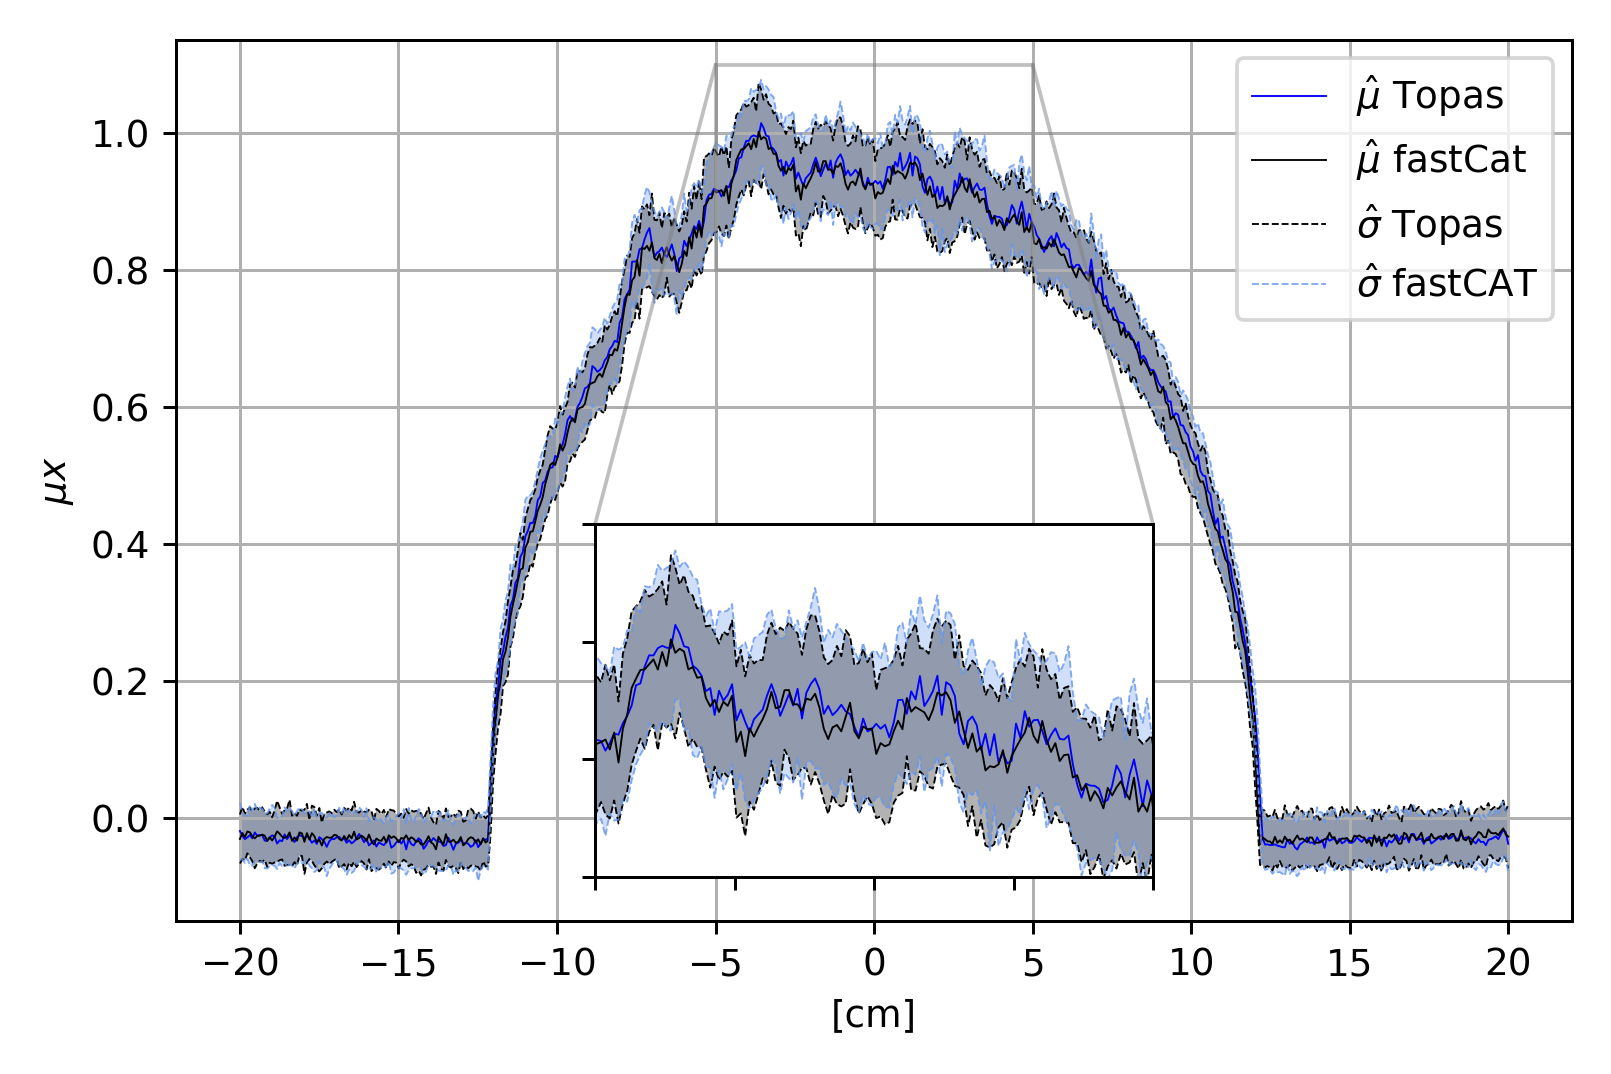

/home/xcite/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  from ipykernel import kernelapp as app
/home/xcite/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  app.launch_new_instance()
/home/xcite/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/home/xcite/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/home/xcite/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDepre

(<matplotlib.patches.Rectangle at 0x7f488856d690>,
 (<matplotlib.patches.ConnectionPatch at 0x7f48873fb710>,
  <matplotlib.patches.ConnectionPatch at 0x7f4887410a90>))

In [3]:
topas = np.load('/home/xcite/scintillators/Catphan_dose/batch_submission/projs_new_npys.npy')

# for figures W25CWOcoh_working.npy
fastCat = np.load('/home/xcite/fastCAT/xpecgen/data/projs/similar_noise7.npy')#fastCat_topas_equiv_8cm_W.npy')

fig = plt.figure(figsize=[6,4],dpi=300)

ax = fig.add_subplot(111)

plt.fill_between(np.linspace(-20,20,512),np.mean(fastCat.T[:,:,0],1)/10-np.std(fastCat.T[:,:,0],1)/10, 
                 np.mean(fastCat.T[:,:,0],1)/10+np.std(fastCat.T[:,:,0],1)/10 ,alpha=0.3, facecolor='cornflowerblue')

plt.fill_between(np.linspace(-20,20,512),np.mean(topas.T[:,:64,0],1)-np.std(topas.T[:,:64,0],1),
                 np.mean(topas.T[:,:64,0],1)+np.std(topas.T[:,:64,0],1),alpha=0.3, facecolor='k')
plt.plot(np.linspace(-20,20,512),np.mean(fastCat.T[:,:,0],1)/10,lineWidth= .5,color='b')
plt.plot(np.linspace(-20,20,512),np.mean(topas.T[:,:64,0],1),lineWidth= .5,color='k')
    
plt.plot(np.linspace(-20,20,512),np.mean(topas.T[:,:64,0],1)+np.std(topas.T[:,:64,0],1),'k--',lineWidth= .5)

plt.plot(np.linspace(-20,20,512),np.mean(fastCat.T[:,:,0],1)/10+np.std(fastCat.T[:,:,0],1)/10,'--',lineWidth= .5,color='cornflowerblue',alpha=0.8)

plt.plot(np.linspace(-20,20,512),np.mean(topas.T[:,:64,0],1)-np.std(topas.T[:,:64,0],1),'k--',lineWidth= .5)

plt.plot(np.linspace(-20,20,512),np.mean(fastCat.T[:,:,0],1)/10-np.std(fastCat.T[:,:,0],1)/10,'--',lineWidth= .5,color='cornflowerblue',alpha=0.8)

plt.legend(['$\hat{\mu}$ Topas','$\hat{\mu}$ fastCat', '$\hat{\sigma}$ Topas', '$\hat{\sigma}$ fastCAT'])
            

# inset axes....
axins = ax.inset_axes([0.3, 0.05, 0.4, 0.4])

axins.fill_between(np.linspace(-20,20,512),np.mean(fastCat.T[:,:,0],1)/10-np.std(fastCat.T[:,:,0],1)/10, 
                 np.mean(fastCat.T[:,:,0],1)/10+np.std(fastCat.T[:,:,0],1)/10 ,alpha=0.3, facecolor='cornflowerblue')

axins.fill_between(np.linspace(-20,20,512),np.mean(topas.T[:,:64,0],1)-np.std(topas.T[:,:64,0],1),
                 np.mean(topas.T[:,:64,0],1)+np.std(topas.T[:,:64,0],1),alpha=0.3, facecolor='k')

axins.plot(np.linspace(-20,20,512),np.mean(topas.T[:,:64,0],1)+np.std(topas.T[:,:64,0],1),'k--',lineWidth= .5)

axins.plot(np.linspace(-20,20,512),np.mean(fastCat.T[:,:,0],1)/10+np.std(fastCat.T[:,:,0],1)/10,'--',lineWidth= .5,color='cornflowerblue',alpha=0.8)

axins.plot(np.linspace(-20,20,512),np.mean(topas.T[:,:64,0],1)-np.std(topas.T[:,:64,0],1),'k--',lineWidth= .5)

axins.plot(np.linspace(-20,20,512),np.mean(fastCat.T[:,:,0],1)/10-np.std(fastCat.T[:,:,0],1)/10,'--',lineWidth= .5,color='cornflowerblue',alpha=0.8)

axins.plot(np.linspace(-20,20,512),np.mean(fastCat.T[:,:,0],1)/10,lineWidth= .5,color='b')
axins.plot(np.linspace(-20,20,512),np.mean(topas.T[:,:64,0],1),lineWidth= .5,color='k')

plt.grid()
# sub region of the original image
x1, x2, y1, y2 = -5, 5, 0.8, 1.1
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')

plt.ylabel('$\mu x$')
plt.xlabel('[cm]')
plt.tight_layout()

ax.indicate_inset_zoom(axins)